Import some packages.

In [189]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import io 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

Read in the train dataset, generate some descriptive statistics.



In [3]:
from google.colab import files 
uploaded = files.upload()

Saving cs-training.csv to cs-training.csv


In [5]:
uploaded2 = files.upload()

Saving cs-test.csv to cs-test.csv


In [129]:
train = pd.read_csv(io.BytesIO(uploaded['cs-training.csv']), index_col = 0) 
test = pd.read_csv(io.BytesIO(uploaded2['cs-test.csv']), index_col = 0) 
trainX = train.iloc[:, 1:11]
trainy = train.iloc[:,0]
testX = test.iloc[:, 1:11]

In [130]:
train.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [131]:
trainX.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


We can see that there are some NA values in a couple of the columns of the dataset.

In [132]:
trainX.isna().sum()

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Impute NA values for both train X and test X using an iterative learner. 



In [133]:
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(trainX)
trainX = pd.DataFrame(imp_mean.transform(trainX))
imp_mean.fit(testX)
testX = pd.DataFrame(imp_mean.transform(testX))

In [134]:
train = pd.concat([train.iloc[0:149999, 0], trainX.iloc[1:, :]], axis = 1)

In [135]:
train[9] = train[9].round() # make sure that the imputer didn't make any entries in the number of dependents column non-integers.
train = train[train[9] >= 0 ] # delete any entries that the imputer made negative for number of dependents.

Now, we'll look at the distribution of our response variable, which is "SeriousDlqin2yrs"

In [136]:
trainy.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [137]:
trainy.value_counts()[1]/(trainy.value_counts()[0] + trainy.value_counts()[1])

0.06684

Those who did experience a greater than 90 day past due delinquency of worse in the past two years form a small fraction of the observations. At the same time, based on the summary statistics generated earlier, there might be some curious outliers in the dataset that we won't want to include. Let's investigate the distributions of some of the columns a bit further. First, age:

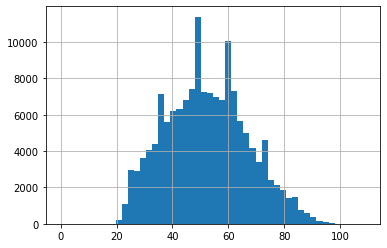

In [138]:
train[1].hist(bins = 50)

There appears to be nothing out of the ordinary here. Same deal with columns 5, 7, and 9 with the dataset. There are some relatively high values for each of these, but they are relatively infrequent. 

In [139]:
train[5].value_counts().sort_index()

0.0      1888
1.0      4438
2.0      6666
3.0      9058
4.0     11609
5.0     12931
6.0     13614
7.0     13245
8.0     12560
9.0     11355
10.0     9624
11.0     8321
12.0     7005
13.0     5666
14.0     4546
15.0     3645
16.0     3000
17.0     2370
18.0     1874
19.0     1433
20.0     1169
21.0      864
22.0      685
23.0      533
24.0      422
25.0      337
26.0      239
27.0      194
28.0      150
29.0      114
30.0       88
31.0       74
32.0       52
33.0       47
34.0       35
35.0       27
36.0       18
37.0        7
38.0       13
39.0        9
40.0       10
41.0        4
42.0        8
43.0        8
44.0        2
45.0        8
46.0        3
47.0        2
48.0        6
49.0        4
50.0        2
51.0        2
52.0        3
53.0        1
54.0        4
56.0        2
57.0        2
58.0        1
Name: 5, dtype: int64

In [140]:
train[7].value_counts().sort_index()

0.0     56188
1.0     52338
2.0     31522
3.0      6299
4.0      2169
5.0       689
6.0       319
7.0       171
8.0        93
9.0        78
10.0       37
11.0       23
12.0       18
13.0       15
14.0        7
15.0        7
16.0        4
17.0        4
18.0        2
19.0        2
20.0        2
21.0        1
23.0        2
25.0        3
26.0        1
29.0        1
32.0        1
54.0        1
Name: 7, dtype: int64

In [141]:
train[9].value_counts()

0.0     88788
1.0     28350
2.0     19523
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: 9, dtype: int64

We'll also look at the top 1 percent of values for variables 0 and 3. We'd expect very high values for both to be correlated with an increased chance of a positive value for the response variable, but we see that the proportion of positives for these subsets are actually less than the proportion of positives for the training set at large. So there doesn't appear to be much signal in these observations, and it's a relatively small set of observations anyways, so we'll get rid of them.

In [159]:
train[train[0] > train[0].quantile(0.99)]["SeriousDlqin2yrs"].mean()

0.06333333333333334

In [161]:
train[train[3] > train[3].quantile(0.99)]["SeriousDlqin2yrs"].mean()

0.06066666666666667

Looking at variables 2, 6, and 8, now:

In [156]:
train[2].value_counts().sort_index()

0.0     126016
1.0      16033
2.0       4597
3.0       1754
4.0        747
5.0        342
6.0        140
7.0         54
8.0         25
9.0         12
10.0         4
11.0         1
12.0         2
13.0         1
96.0         5
98.0       264
Name: 2, dtype: int64

In [157]:
train[6].value_counts().sort_index()

0.0     141659
1.0       5243
2.0       1555
3.0        667
4.0        291
5.0        131
6.0         80
7.0         38
8.0         21
9.0         19
10.0         8
11.0         5
12.0         2
13.0         4
14.0         2
15.0         2
17.0         1
96.0         5
98.0       264
Name: 6, dtype: int64

In [158]:
train[8].value_counts().sort_index()

0.0     142393
1.0       5731
2.0       1118
3.0        318
4.0        105
5.0         34
6.0         16
7.0          9
8.0          2
9.0          1
11.0         1
96.0         5
98.0       264
Name: 8, dtype: int64

Hmm. Whereas most of the observations are confined to below 20 for these variables, 269 observations take on values of 96 or 98. We'll toss out these egregious outliers too. 

In [162]:
train_short = train[(train[2] <= 95) & (train[6] <= 95) & (train[8] <= 95) & (train[0] <= train[0].quantile(0.99)) & (train[3] <= train[3].quantile(0.99))]

In [163]:
train_short.reset_index(drop = True, inplace = True)
train_short

,SeriousDlqin2yrs,0,1,2,3,4,5,6,7,8,9
0,1,0.957151,40.0,0.0,0.121876,2600.000000,4.0,0.0,0.0,0.0,1.0
1,0,0.658180,38.0,1.0,0.085113,3042.000000,2.0,1.0,0.0,0.0,0.0
2,0,0.233810,30.0,0.0,0.036050,3300.000000,5.0,0.0,0.0,0.0,0.0
3,0,0.907239,49.0,1.0,0.024926,63588.000000,7.0,0.0,1.0,0.0,0.0
4,0,0.213179,74.0,0.0,0.375607,3500.000000,3.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
146734,0,0.040674,74.0,0.0,0.225131,2100.000000,4.0,0.0,1.0,0.0,0.0
146735,0,0.299745,44.0,0.0,0.716562,5584.000000,4.0,0.0,1.0,0.0,2.0
146736,0,0.246044,58.0,0.0,3870.000000,3203.978815,18.0,0.0,1.0,0.0,0.0
146737,0,0.000000,30.0,0.0,0.000000,5716.000000,4.0,0.0,0.0,0.0,0.0


In [164]:
train_short.describe()

,SeriousDlqin2yrs,0,1,2,3,4,5,6,7,8,9
count,146739.000000,146739.000000,146739.000000,146739.000000,146739.000000,1.467390e+05,146739.000000,146739.000000,146739.000000,146739.000000,146739.000000
mean,0.066962,0.310998,52.387702,0.237708,270.374387,6.285424e+03,8.453363,0.083093,1.005316,0.060413,0.752077
std,0.249958,0.344374,14.785770,0.684892,781.996898,1.304998e+04,5.119470,0.456909,1.103572,0.315361,1.104598
min,0.000000,0.000000,0.000000,0.000000,0.000000,-2.793003e+02,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029064,41.000000,0.000000,0.174164,3.500000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.147904,52.000000,0.000000,0.363023,5.041000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.536407,63.000000,0.000000,0.818118,7.500000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,1.092954,109.000000,13.000000,4978.000000,3.008750e+06,58.000000,17.000000,54.000000,11.000000,20.000000


Standardize the data

In [168]:
trainX = train_short.iloc[:, 1:11]
trainy = train_short.iloc[:,0]
trainX = (trainX - trainX.mean())/trainX.std()

We'll first try to do a basic kNN classifier on the dataset, using 5 fold cross-validation to select the best k from 1 to 10

In [170]:
ktests = range(1,11)
kscores = []

for k in ktests:
  knn = KNeighborsClassifier(n_neighbors = k)
  scores = cross_val_score(knn, trainX, trainy, cv = 5, scoring = 'accuracy')
  kscores.append(scores.mean())

In [171]:
kscores

[0.8746549844832738,
 0.9288737150985126,
 0.9218885241673981,
 0.9320085327004142,
 0.9308431969841724,
 0.9328058654886833,
 0.932431048947348,
 0.9329557923838738,
 0.9328944587173542,
 0.9330103110437488]

Divide the training set into a random "train" and "test" set, and determine the ROC using 10NN. 

In [172]:
trainX1, trainX2, trainy1, trainy2 = train_test_split(trainX, trainy, test_size=0.2)

In [204]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(trainX1,trainy1)
y_scores = knn.predict_proba(trainX2) # get scores from the "test" set within the training set
knnscores = knn.predict_proba(testX) # get kNN scores on the actual test set
fpr, tpr, threshold = roc_curve(trainy2, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

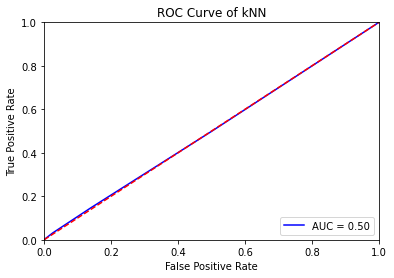

In [205]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

Yuck. Pretty bad. kNN is probably not the way to go here. Let's try SVM. 

In [ ]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(trainX, trainy)
optsvm = grid_search.best_params_